In [ ]:
# poetry install
# poetry config virtualenvs.in-project true
# Select kernel -> .venv

In [18]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [19]:
# テスト用のデータセットを取得.
X,y = shap.datasets.adult()
# ディスプレイ用のデータセット (数値化されていない文字列データが入っている)
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [20]:
# データ件数
len(X)

32561

In [21]:
# LGBM のパラメータ
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}
# LGBM のアップデートで、early_stopping と verbose_eval はコールバック関数で渡す必要
verbose_eval = 1000

model = lgb.train(params, d_train, 10000, valid_sets=[d_test],
                            callbacks=[lgb.early_stopping(stopping_rounds=50, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval)] # コマンドライン出力用コールバック関数
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


In [23]:
# 作成された model の feature name などを見てみる
m = model.dump_model()
m["feature_names"]

['Age',
 'Workclass',
 'Education-Num',
 'Marital_Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital_Gain',
 'Capital_Loss',
 'Hours_per_week',
 'Country']

In [26]:
# create shap explainer 
# 入力として X は必要. 後で X の部分集合でやってみよう
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [50]:
# shap_values の 中身を見てみる.
print(f'{len(shap_values)=}') # 1 or 0 のため 2.
print(f'{len(shap_values[0])=}') # データ件数.
print(f'{len(shap_values[1])=}') # データ件数. (どちらも同数ある)
print(f'{len(shap_values[0][0])=}') # feature 数.


len(shap_values)=2
len(shap_values[0])=32561
len(shap_values[1])=32561
len(shap_values[0][0])=12


In [54]:
# base_value は 期待値
# shap_values[1][0,:] は 1 についての shap_value かつ、0番目のデータの 全 featureに関するデータ
shap.force_plot(base_value=explainer.expected_value[1],
                 shap_values=shap_values[1][0,:], features=X_display.iloc[0,:])


In [55]:
# base_value は 期待値
# shap_values[0][0,:] は 0 についての shap_value かつ、0番目のデータの 全 featureに関するデータ
shap.force_plot(base_value=explainer.expected_value[0],
                 shap_values=shap_values[0][0,:], features=X_display.iloc[0,:])


In [40]:
explainer.expected_value[1]

-2.4326672543732544

In [49]:
len(shap_values[0])

32561

In [56]:
# 1000 件のデータに付いて 横に並べて force を見てみる
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


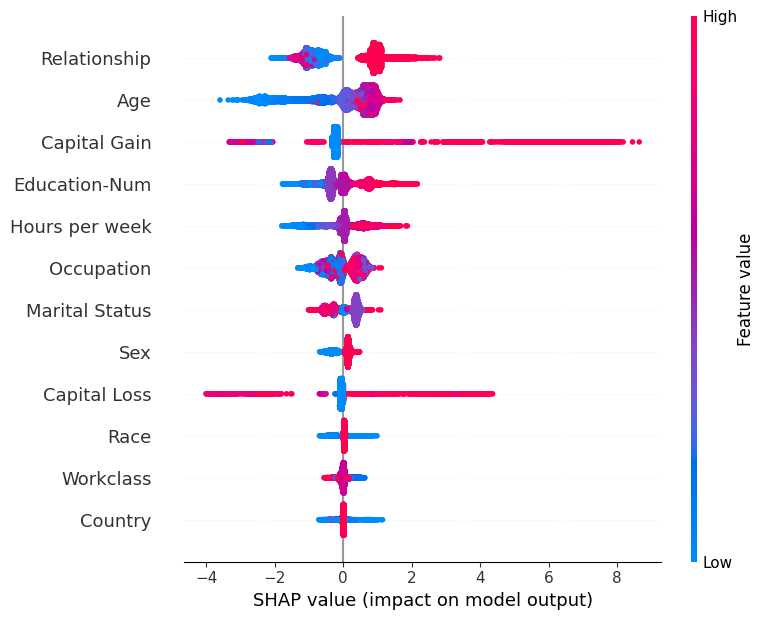

In [58]:
# feature の値が高い(赤)、値が低い(青)が SHAP にどの程度関係あるか確認する
shap.summary_plot(shap_values[1], X)


In [ ]:
# 交互関係のありそうな feature を探す.
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display)

IndexError: index 9720 is out of bounds for axis 0 with size 0

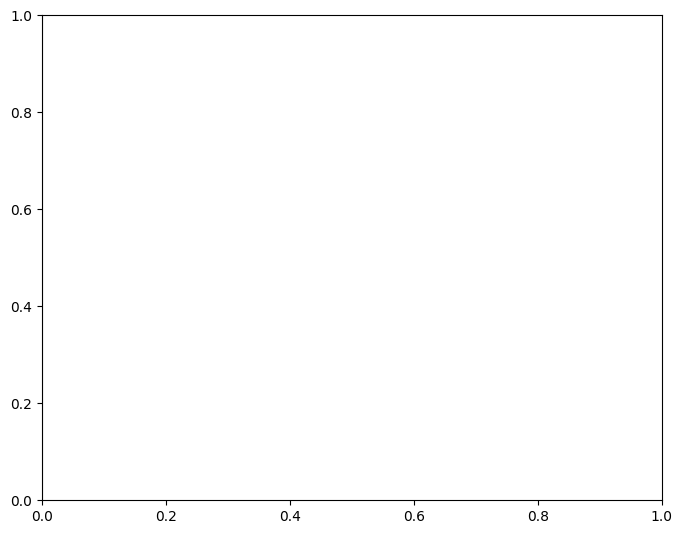

In [70]:
male_X = X[X_display["Sex"] == 'Male']
#feature の値が高い(赤)、値が低い(青)が SHAP にどの程度関係あるか確認する
shap.summary_plot(shap_values[1], male_X)
# この使い方はエラーになる shap_values を作ったときと同じデータが必要

21790


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


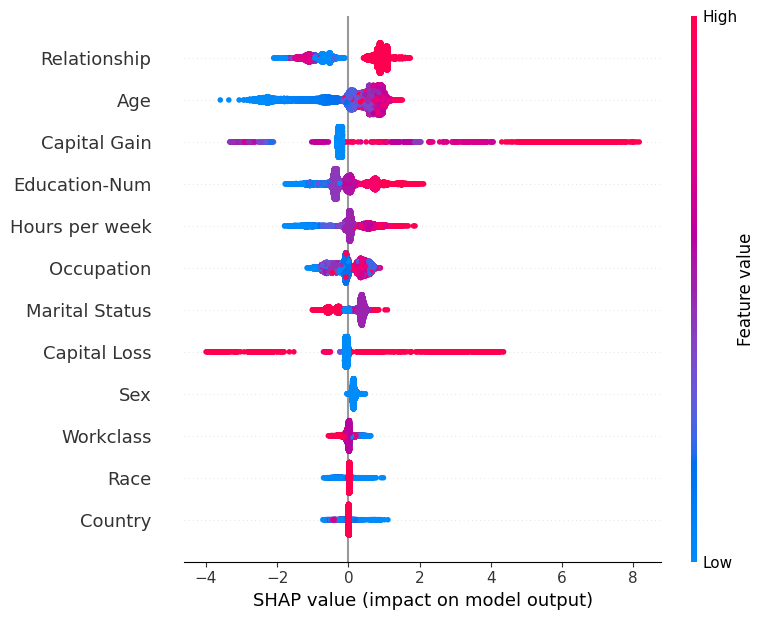

In [85]:
# create shap explainer 
# 部分集合でやってみよう
male_explainer = shap.TreeExplainer(model)
# 部分データについて shap を出してみる
male_X = X[X["Sex"] == 1.0]
print(f'{len(male_X)}')
#feature の値が高い(赤)、値が低い(青)が SHAP にどの程度関係あるか確認する
male_shap_values = male_explainer.shap_values(male_X)
shap.summary_plot(male_shap_values[1], male_X)

21790


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


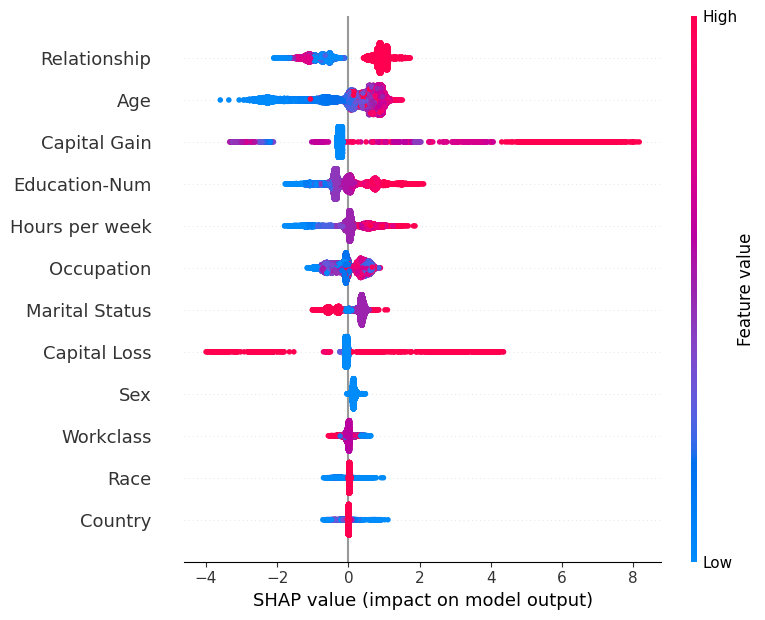

In [84]:
# create shap explainer 
# 部分集合でやってみよう
female_explainer = shap.TreeExplainer(model)
# 部分データについて shap を出してみる
female_X = X[X["Sex"] == 1.0]
print(f'{len(female_X)}')
#feature の値が高い(赤)、値が低い(青)が SHAP にどの程度関係あるか確認する
female_shap_values = female_explainer.shap_values(female_X)
shap.summary_plot(female_shap_values[1], female_X)

In [78]:
len(male_X)

21790

In [81]:
# そもそも display には何が入っている
X_display

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,Private,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States
32557,40.0,Private,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States
32558,58.0,Private,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States
32559,22.0,Private,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


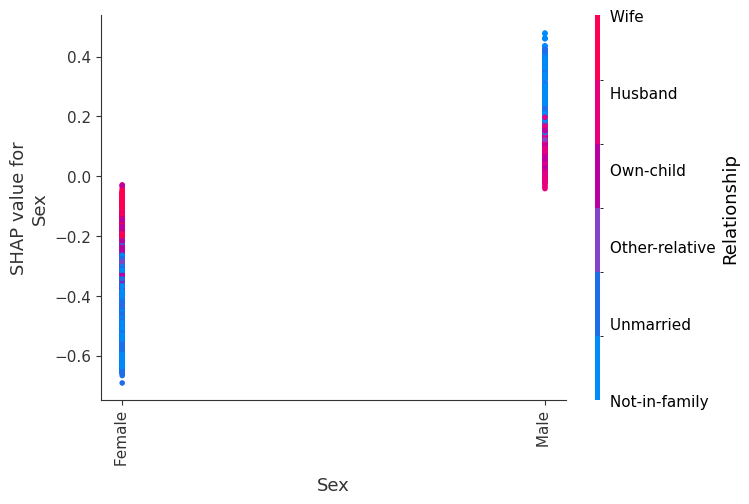

In [83]:
# create shap explainer 
explainer = shap.TreeExplainer(model)
# 今度は男女別じゃなくて全データ
shap_values = explainer.shap_values(X)

shap.dependence_plot("Sex", shap_values[1], X, display_features=X_display)

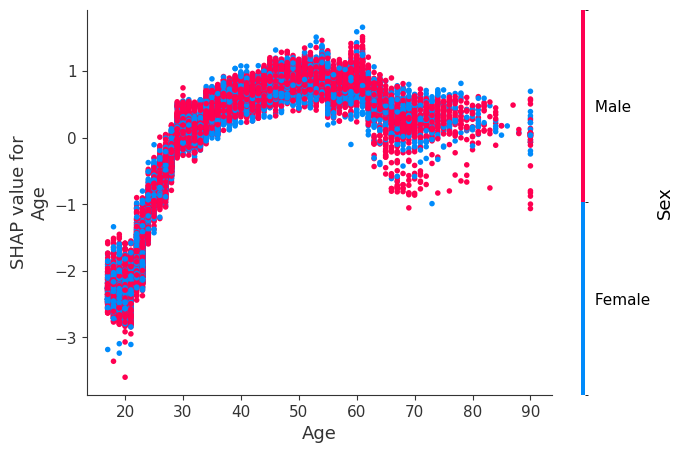

In [86]:
#年齢と性別との交互作用 自動じゃなくて指定もできる
shap.dependence_plot("Age", shap_values[1], X, display_features=X_display, interaction_index="Sex")
